OPENCLASSROOMS  
Parcours Data Scientist  
**Projet 7: Implémentez un modèle de scoring**  
Etudiant: Eric Wendling  
Mentor: Julien Heiduk  
Date: 14/08/2020

### Import des modules Python

In [1]:
import pandas as pd
print('Pandas',pd.__version__)
pd.options.mode.chained_assignment = None

import numpy as np
print('Numpy',np.__version__)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
print('Matplotlib',matplotlib.__version__)

import joblib
from joblib import dump, load

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from dash_table import DataTable

import plotly.express as px
import plotly.graph_objects as go

Pandas 1.0.3
Numpy 1.18.3
Matplotlib 3.2.1


### Initialisation

In [2]:
colors = {'background_1': '#FFFFFF',
          'text': '#000000',
          'background_2': '#C0C0C0',
          'text_2': '#000000'}

In [3]:
%store -r feature_importances_top

In [4]:
df_fi = feature_importances_top
df_fi.reset_index(drop=True, inplace=True)
df_fi.head()

,feature,importance
0,EXT_SOURCE_3,112.0
1,EXT_SOURCE_2,107.4
2,DAYS_BIRTH,78.4
3,EXT_SOURCE_1,75.4
4,AMT_CREDIT,72.4


On normalise les valeurs de la variable **'importance'**.

In [5]:
df_imp = df_fi[['importance']]

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
imp_std = min_max_scaler.fit_transform(df_fi[['importance']])
df_imp_std = pd.DataFrame(imp_std)

df_fi = df_fi.merge(df_imp_std, left_index=True, right_index=True)
del df_fi['importance']
df_fi.columns = ['feature','importance']
df_fi['importance'] = round((df_fi['importance']),2)*100
df_fi['importance']=df_fi['importance'].astype('int')
df_fi.head()

,feature,importance
0,EXT_SOURCE_3,100
1,EXT_SOURCE_2,95
2,DAYS_BIRTH,64
3,EXT_SOURCE_1,61
4,AMT_CREDIT,57


In [6]:
path_features = '../OC_DS_P7/features_app/'
path_results = '../OC_DS_P7/results_app/'

df_app_name = 'df_app_2'

In [7]:
# Jeu de données d'entraînement avec étiquettes

feature_names = joblib.load(path_features+'feature_names.joblib')

# Jeu de données de test avec étiquettes

test_features = joblib.load(path_features+'test_features.joblib')
print('test_features.shape:',test_features.shape)
test_ids_ = joblib.load(path_features+'test_ids.joblib')
print('test_ids_.shape:',test_ids_.shape)
test_pred = joblib.load(path_features+'test_pred.joblib')
print('test_pred.shape:',test_pred.shape)
test_labels = joblib.load(path_features+'test_labels.joblib')
print('test_labels.shape:',test_labels.shape)

# Jeu de données de test sans étiquette

test_sub_features = joblib.load(path_features+'test_sub_features.joblib')
print('\ntest_sub_features.shape:',test_sub_features.shape)
test_sub_ids_ = joblib.load(path_features+'test_sub_ids.joblib')
print('test_sub_ids_.shape:',test_sub_ids_.shape)
test_sub_pred = joblib.load(path_features+'test_sub_pred.joblib')
print('test_sub_pred.shape:',test_sub_pred.shape)

test_features.shape: (61503, 50)
test_ids_.shape: (61503,)
test_pred.shape: (61503,)
test_labels.shape: (61503,)

test_sub_features.shape: (48744, 50)
test_sub_ids_.shape: (48744,)
test_sub_pred.shape: (48744,)


In [8]:
# Conversion SK_ID_CURR au format texte (string)

# test

df_test_ids = pd.DataFrame(test_ids_)

val_str_list = []

for i in df_test_ids.index:
    val_int = df_test_ids['SK_ID_CURR'].loc[i]
    val_str = str(val_int)
    val_str = val_str+'_'
    val_str_list.append(val_str)
    
df_test_ids['SK_ID_CURR_str'] = val_str_list
df_test_ids.columns = ['SK_ID_CURR_num','SK_ID_CURR']
df_test_ids_ = df_test_ids[['SK_ID_CURR_num','SK_ID_CURR']]
df_test_ids = df_test_ids[['SK_ID_CURR']]

# test_sub

df_test_sub_ids = pd.DataFrame(test_sub_ids_)

val_str_list = []

for i in df_test_sub_ids.index:
    val_int = df_test_sub_ids['SK_ID_CURR'].loc[i]
    val_str = str(val_int)
    val_str = val_str+'_'
    val_str_list.append(val_str)
    
df_test_sub_ids['SK_ID_CURR_str'] = val_str_list
df_test_sub_ids.columns = ['SK_ID_CURR_num','SK_ID_CURR']
df_test_sub_ids_ = df_test_sub_ids[['SK_ID_CURR_num','SK_ID_CURR']]
df_test_sub_ids = df_test_sub_ids[['SK_ID_CURR']]

In [9]:
test_features_with_id = df_test_ids.merge(test_features, left_index=True, right_index=True )
test_features_with_id = round(test_features_with_id,3)
test_features_with_id.sort_values('SK_ID_CURR').head()

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,client_installments_payments_AMT_PAYMENT_min_min,bureau_DAYS_CREDIT_ENDDATE_max,...,bureau_AMT_CREDIT_SUM_max,previous_application_DAYS_LAST_DUE_sum,previous_application_SELLERPLACE_AREA_max,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,AMT_REQ_CREDIT_BUREAU_QRT,bureau_CREDIT_TYPE_Creditcard_count,FLAG_OWN_CAR_Y,OWN_CAR_AGE,previous_application_HOUR_APPR_PROCESS_START_max
0,100002_,0.139,0.263,-9461,0.083,406597.5,24700.5,-637,9251.775,780.0,...,450000.0,-25.0,500.0,9251.775,9251.775,0.0,4.0,0,0.0,9.0
17,100021_,0.000,0.684,-9776,0.000,270000.0,13500.0,-191,2705.760,0.0,...,0.0,726690.0,6000.0,10686.165,33750.000,0.0,0.0,0,0.0,19.0
18,100022_,0.557,0.706,-17718,0.000,157500.0,7875.0,-7804,6765.975,1439.0,...,765000.0,365243.0,-1.0,6765.975,6765.975,0.0,0.0,0,0.0,18.0
22,100026_,0.359,0.457,-11146,0.000,497520.0,32521.5,-4306,23531.175,1581.0,...,2700000.0,-1654.0,200.0,33193.665,42778.845,0.0,0.0,0,0.0,12.0
23,100027_,0.669,0.624,-24827,0.000,239850.0,23850.0,365243,21553.740,944.0,...,427500.0,-605.0,2200.0,24067.755,28077.570,0.0,0.0,0,0.0,16.0


In [10]:
test_features_with_id_default = test_features_with_id.iloc[0,:].copy()
test_features_with_id_default = pd.DataFrame(test_features_with_id_default).T
test_features_with_id_default.iloc[0,1:] = 0
test_features_with_id_default.iloc[0,0] = '0_'
test_features_with_id_default

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,client_installments_payments_AMT_PAYMENT_min_min,bureau_DAYS_CREDIT_ENDDATE_max,...,bureau_AMT_CREDIT_SUM_max,previous_application_DAYS_LAST_DUE_sum,previous_application_SELLERPLACE_AREA_max,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,AMT_REQ_CREDIT_BUREAU_QRT,bureau_CREDIT_TYPE_Creditcard_count,FLAG_OWN_CAR_Y,OWN_CAR_AGE,previous_application_HOUR_APPR_PROCESS_START_max
179042,0_,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_features_with_id = pd.concat([test_features_with_id,test_features_with_id_default])
test_features_with_id.sort_values('SK_ID_CURR').head()

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,client_installments_payments_AMT_PAYMENT_min_min,bureau_DAYS_CREDIT_ENDDATE_max,...,bureau_AMT_CREDIT_SUM_max,previous_application_DAYS_LAST_DUE_sum,previous_application_SELLERPLACE_AREA_max,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,AMT_REQ_CREDIT_BUREAU_QRT,bureau_CREDIT_TYPE_Creditcard_count,FLAG_OWN_CAR_Y,OWN_CAR_AGE,previous_application_HOUR_APPR_PROCESS_START_max
179042,0_,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,100002_,0.139,0.263,-9461,0.083,406598,24700.5,-637,9251.77,780,...,450000,-25,500,9251.77,9251.77,0,4,0,0,9
17,100021_,0,0.684,-9776,0,270000,13500,-191,2705.76,0,...,0,726690,6000,10686.2,33750,0,0,0,0,19
18,100022_,0.557,0.706,-17718,0,157500,7875,-7804,6765.98,1439,...,765000,365243,-1,6765.98,6765.98,0,0,0,0,18
22,100026_,0.359,0.457,-11146,0,497520,32521.5,-4306,23531.2,1581,...,2.7e+06,-1654,200,33193.7,42778.8,0,0,0,0,12


In [12]:
test_sub_features_with_id = df_test_sub_ids.merge(test_sub_features, left_index=True, right_index=True )
test_sub_features_with_id = round(test_sub_features_with_id,3)
test_sub_features_with_id.sort_values('SK_ID_CURR').head()

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,client_installments_payments_AMT_PAYMENT_min_min,bureau_DAYS_CREDIT_ENDDATE_max,...,bureau_AMT_CREDIT_SUM_max,previous_application_DAYS_LAST_DUE_sum,previous_application_SELLERPLACE_AREA_max,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,AMT_REQ_CREDIT_BUREAU_QRT,bureau_CREDIT_TYPE_Creditcard_count,FLAG_OWN_CAR_Y,OWN_CAR_AGE,previous_application_HOUR_APPR_PROCESS_START_max
0,100001_,0.160,0.790,-19241,0.753,568800.0,20560.5,-2329,3951.000,1778.0,...,378000.0,-1619.0,23.0,3951.000,3951.000,0.0,0.0,0,0.0,13.0
1,100005_,0.433,0.292,-18064,0.565,222768.0,17370.0,-4469,4813.200,1324.0,...,568800.0,-466.0,37.0,4813.200,4813.200,0.0,1.0,0,0.0,11.0
2,100013_,0.611,0.700,-20038,0.000,663264.0,69777.0,-4458,6.165,-567.0,...,1262250.0,-2147.0,300.0,11478.195,23153.985,1.0,0.0,1,5.0,18.0
3,100028_,0.613,0.510,-13976,0.526,1575000.0,49018.5,-1866,1.170,30885.0,...,393750.0,363514.0,3500.0,8091.585,11250.000,0.0,5.0,0,0.0,13.0
4,100038_,0.000,0.426,-13040,0.202,625500.0,32067.0,-2191,11097.450,0.0,...,0.0,-457.0,27.0,17782.155,24463.710,0.0,0.0,1,16.0,7.0


In [13]:
test_sub_features_with_id = pd.concat([test_sub_features_with_id,test_features_with_id_default])
test_sub_features_with_id.sort_values('SK_ID_CURR').head()

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,client_installments_payments_AMT_PAYMENT_min_min,bureau_DAYS_CREDIT_ENDDATE_max,...,bureau_AMT_CREDIT_SUM_max,previous_application_DAYS_LAST_DUE_sum,previous_application_SELLERPLACE_AREA_max,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,AMT_REQ_CREDIT_BUREAU_QRT,bureau_CREDIT_TYPE_Creditcard_count,FLAG_OWN_CAR_Y,OWN_CAR_AGE,previous_application_HOUR_APPR_PROCESS_START_max
179042,0_,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,100001_,0.16,0.79,-19241,0.753,568800,20560.5,-2329,3951,1778,...,378000,-1619,23,3951,3951,0,0,0,0,13
1,100005_,0.433,0.292,-18064,0.565,222768,17370,-4469,4813.2,1324,...,568800,-466,37,4813.2,4813.2,0,1,0,0,11
2,100013_,0.611,0.7,-20038,0,663264,69777,-4458,6.165,-567,...,1.26225e+06,-2147,300,11478.2,23154,1,0,1,5,18
3,100028_,0.613,0.51,-13976,0.526,1.575e+06,49018.5,-1866,1.17,30885,...,393750,363514,3500,8091.59,11250,0,5,0,0,13


In [14]:
# Features values per customer
feat_val_per_cust = test_sub_features_with_id[test_sub_features_with_id['SK_ID_CURR']=='0_'].T
feat_val_per_cust.columns = ['value']
feat_val_per_cust.reset_index(inplace=True)

# On fusionne les variables importantes avec les variables du client
feat_val_per_cust_2 = feat_val_per_cust.merge(df_fi,
                                              left_on='index', right_on='feature').sort_values('importance',ascending=False)
feat_val_per_cust_2 = feat_val_per_cust_2[['feature','value','importance']]
feat_val_per_cust_2 = round(feat_val_per_cust_2,2)
feat_val_per_cust_2.head()

,feature,value,importance
0,EXT_SOURCE_3,0,100
1,EXT_SOURCE_2,0,95
2,DAYS_BIRTH,0,64
3,EXT_SOURCE_1,0,61
4,AMT_CREDIT,0,57


In [15]:
[fpr, tpr, thr] = metrics.roc_curve(test_labels, test_pred)
df_fpr = pd.DataFrame(fpr)
df_tpr = pd.DataFrame(tpr)

df_roc = df_fpr.merge(df_tpr, left_index=True, right_index=True)
df_roc.columns = ['fpr','tpr']
df_roc

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.000201
2,0.000000,0.001204
3,0.000018,0.001204
4,0.000018,0.001807
...,...,...
8139,0.990941,0.999599
8140,0.990941,0.999799
8141,0.996550,0.999799
8142,0.996550,1.000000


In [16]:
auc_val = round(metrics.auc(fpr, tpr),3)
auc_val

0.784

In [17]:
metric_ = 'GainNorm'
solvability_threshold_g_norm = joblib.load('../OC_DS_P7/hyperopt/'+df_app_name+'_'+metric_+'_threshold_g_norm.joblib')
print ("Seuil : %.2f" % solvability_threshold_g_norm)

idx = np.max(np.where(thr > solvability_threshold_g_norm))
print ("Seuil : %.2f" % thr[idx])

Seuil : 0.33
Seuil : 0.33


#### Gain normalisé

In [18]:
df_g_norm = joblib.load(path_results+'df_g_norm.joblib')

In [19]:
# Ce code permet d'identifier, dans le dataframe df_g_norm la valeur de seuil la plus proche du seuil optimal
# (solvability_threshold_g_norm), cela dans l'objectif d'identifier le gain optimal

threshold_fit_list = []

# Pour chaque valeur du seuil
for i in df_g_norm['seuil']:
    # On calcule la différence entre les valeurs de seuils
    threshold_fit = solvability_threshold_g_norm - i
    # On ajoute la différence à la liste
    threshold_fit_list.append(abs(threshold_fit))

# On identifie la différence la plus petite (en valeur absolue)
best_threshold_fit = min(threshold_fit_list)
# On identifie le gain correspondant
id_ = threshold_fit_list.index(best_threshold_fit)
g_norm_opt = df_g_norm['g_norm'].loc[id_]
g_norm_opt

0.7076010193622403

#### Scoring

In [20]:
scoring_default = pd.DataFrame({'SK_ID_CURR':'0_',
                                '_N':0.5,
                                '_P':0.5,
                                '_Pred':0},
                               index = [0])
scoring_default

,SK_ID_CURR,_N,_P,_Pred
0,0_,0.5,0.5,0


In [21]:
# test
test_pred_bin = (test_pred > thr[idx])
test_pred_bin = np.array(test_pred_bin > 0) * 1
test_pred_bin = pd.DataFrame(test_pred_bin)

scoring_test = df_test_ids.reset_index(drop=True).merge(pd.DataFrame(test_pred), left_index=True, right_index=True)
scoring_test = scoring_test.merge(test_pred_bin, left_index=True, right_index=True)
scoring_test.columns = ['SK_ID_CURR','_P','_Pred']

scoring_test['_N'] = 1 - scoring_test['_P']
scoring_test = scoring_test[['SK_ID_CURR','_N','_P','_Pred']]
scoring_test = pd.concat([scoring_test,scoring_default])
scoring_test.head()

,SK_ID_CURR,_N,_P,_Pred
0,307474_,0.929682,0.070318,0
1,412537_,0.892077,0.107923,0
2,149084_,0.821276,0.178724,0
3,364692_,0.568706,0.431294,1
4,155423_,0.658160,0.341840,1


In [22]:
scoring_test[scoring_test['SK_ID_CURR'] == '364692_']

,SK_ID_CURR,_N,_P,_Pred
3,364692_,0.568706,0.431294,1


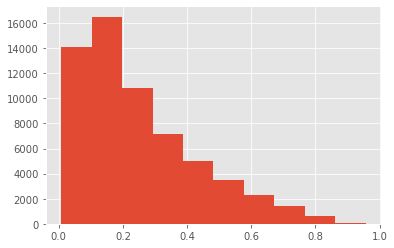

In [23]:
scoring_test['_P'].hist();

#### Liste des identifiants de demande de crédit (test)

In [24]:
scoring_test = scoring_test.sort_values('_P')
list_test_credit_ids = scoring_test[(scoring_test['_P'] >= 0) & (scoring_test['_P'] <= 1)]
list_test_credit_ids = list_test_credit_ids.merge(df_test_ids_, left_on = 'SK_ID_CURR', right_on = 'SK_ID_CURR')
list_test_credit_ids = list_test_credit_ids[['SK_ID_CURR_num']]

list_test_credit_ids.loc[list_test_credit_ids.shape[0]+1,'SK_ID_CURR_num'] = 0
list_test_credit_ids['SK_ID_CURR_num']=list_test_credit_ids['SK_ID_CURR_num'].astype('int')

list_test_credit_ids = list_test_credit_ids['SK_ID_CURR_num']
list_test_credit_ids

0        176880
1        364879
2        421267
3        100889
4        398029
          ...  
61499    365399
61500    296838
61501    409674
61502    236551
61504         0
Name: SK_ID_CURR_num, Length: 61504, dtype: int32

In [25]:
# test_sub
test_sub_pred_bin = (test_sub_pred > thr[idx])
test_sub_pred_bin = np.array(test_sub_pred_bin > 0) * 1
test_sub_pred_bin = pd.DataFrame(test_sub_pred_bin)

scoring_sub = df_test_sub_ids.reset_index(drop=True).merge(pd.DataFrame(test_sub_pred), left_index=True, right_index=True)
scoring_sub = scoring_sub.merge(test_sub_pred_bin, left_index=True, right_index=True)
scoring_sub.columns = ['SK_ID_CURR','_P','_Pred']

scoring_sub['_N'] = 1 - scoring_sub['_P']
scoring_sub = scoring_sub[['SK_ID_CURR','_N','_P','_Pred']]
scoring_sub = pd.concat([scoring_sub,scoring_default])
scoring_sub.head()

,SK_ID_CURR,_N,_P,_Pred
0,100001_,0.863556,0.136444,0
1,100005_,0.543015,0.456985,1
2,100013_,0.925258,0.074742,0
3,100028_,0.899528,0.100472,0
4,100038_,0.410476,0.589524,1


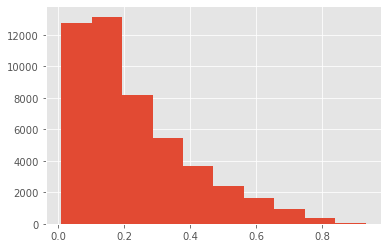

In [26]:
scoring_sub['_P'].hist();

#### Liste des identifiants de demande de crédit (sub)

In [27]:
scoring_sub = scoring_sub.sort_values('_P')
list_test_sub_credit_ids = scoring_sub[(scoring_sub['_P'] >= 0) & (scoring_sub['_P'] <= 1)]
list_test_sub_credit_ids = list_test_sub_credit_ids.merge(df_test_sub_ids_, left_on = 'SK_ID_CURR', right_on = 'SK_ID_CURR')
list_test_sub_credit_ids = list_test_sub_credit_ids[['SK_ID_CURR_num']]

list_test_sub_credit_ids.loc[list_test_sub_credit_ids.shape[0]+1,'SK_ID_CURR_num'] = 0
list_test_sub_credit_ids['SK_ID_CURR_num']=list_test_sub_credit_ids['SK_ID_CURR_num'].astype('int')

list_test_sub_credit_ids = list_test_sub_credit_ids['SK_ID_CURR_num']
list_test_sub_credit_ids

0        294257
1        234695
2        282272
3        443392
4        427622
          ...  
48740    352506
48741    265895
48742    337338
48743    119896
48745         0
Name: SK_ID_CURR_num, Length: 48745, dtype: int32

#### Dataframe du meilleur et du moins bon résultat

In [28]:
# test
best_record = scoring_test.sort_values('_P').head(1)
worst_record = scoring_test.sort_values('_P').tail(1)
best_worst_records = pd.concat([best_record,worst_record])
best_worst_records

,SK_ID_CURR,_N,_P,_Pred
16467,176880_,0.992321,0.007679,0
6302,236551_,0.043613,0.956387,1


In [29]:
# test_sub
best_record_sub = scoring_sub.sort_values('_P').head(1)
worst_record_sub = scoring_sub.sort_values('_P').tail(1)
best_worst_records_sub = pd.concat([best_record_sub,worst_record_sub])
best_worst_records_sub

,SK_ID_CURR,_N,_P,_Pred
26682,294257_,0.990094,0.009906,0
2838,119896_,0.068189,0.931811,1


### Fonction globale

In [30]:
def metrics(recall, x, data_to_pred):
    
    idx = np.max(np.where(thr > recall))

    if recall < 0.5:
        scoring_default.loc[0,'_Pred'] = 1
    elif recall >= 0.5:
        scoring_default.loc[0,'_Pred'] = 0
    
    # test
    test_pred_bin = (test_pred > thr[idx])
    test_pred_bin = np.array(test_pred_bin > 0) * 1
    test_pred_bin = pd.DataFrame(test_pred_bin)

    scoring = df_test_ids.reset_index(drop=True).merge(pd.DataFrame(test_pred), left_index=True, right_index=True)
    scoring = scoring.merge(test_pred_bin, left_index=True, right_index=True)
    scoring.columns = ['SK_ID_CURR','_P','_Pred']

    scoring['_N'] = 1 - scoring['_P']
    scoring = scoring[['SK_ID_CURR','_N','_P','_Pred']]   
    scoring = pd.concat([scoring,scoring_default])
    
    # Prédiction (0 ou 1)
    res_sco_test = scoring[scoring['SK_ID_CURR']==x]['_Pred'].values.tolist() # OPTION_SUB

    # test_sub
    test_sub_pred_bin = (test_sub_pred > thr[idx])
    test_sub_pred_bin = np.array(test_sub_pred_bin > 0) * 1
    test_sub_pred_bin = pd.DataFrame(test_sub_pred_bin)

    scoring_sub = df_test_sub_ids.reset_index(drop=True).merge(pd.DataFrame(test_sub_pred), left_index=True, right_index=True)
    scoring_sub = scoring_sub.merge(test_sub_pred_bin, left_index=True, right_index=True)
    scoring_sub.columns = ['SK_ID_CURR','_P','_Pred']

    scoring_sub['_N'] = 1 - scoring_sub['_P']
    scoring_sub = scoring_sub[['SK_ID_CURR','_N','_P','_Pred']]
    scoring_sub = pd.concat([scoring_sub,scoring_default])
    
    # Prédiction (0 ou 1)    
    res_sco_sub = scoring_sub[scoring_sub['SK_ID_CURR']==x]['_Pred'].values.tolist() # OPTION_SUB
    
    res_sco = res_sco_sub
    
    if data_to_pred == "Subm":
        res_sco = res_sco_sub
    
    elif data_to_pred == "Test":
        res_sco = res_sco_test        

    ####################################################
    ### CALCUL DU GAIN (en fonction du seuil choisi) ###
    ####################################################
    
    # Ce code permet d'identifier, dans le dataframe df_g_norm la valeur de seuil la plus proche du seuil choisi
    # (...), cela dans l'objectif d'identifier le gain en rapport

    threshold_ch = recall

    threshold_fit_list = []

    # Pour chaque valeur du seuil
    for i in df_g_norm['seuil']:
        # On calcule la différence entre les valeurs de seuils
        threshold_fit = threshold_ch - i
        # On ajoute la différence à la liste
        threshold_fit_list.append(abs(threshold_fit))

    # On identifie la différence la plus petite (en valeur absolue)
    best_threshold_fit = min(threshold_fit_list)
    # On identifie le gain correspondant
    id_ = threshold_fit_list.index(best_threshold_fit)
    g_norm_ch = df_g_norm['g_norm'].loc[id_]
    g_norm_ch = round(g_norm_ch,2)

    ############################
    ### MATRICE DE CONFUSION ###
    ############################

    test_true = pd.DataFrame(test_labels).reset_index(drop=True)

    scoring_vs_true = scoring.merge(test_true, left_index=True, right_index=True)
    scoring_vs_true = scoring_vs_true.sort_index()

    x_pred = scoring_vs_true['_Pred']
    y_true = scoring_vs_true['TARGET']

    tn, fp, fn, tp = confusion_matrix(y_true, x_pred).ravel()   
    
    #################
    ### Métriques ###
    #################
    
    sensibilite = round(tpr[idx],2)
    specificite = round(1-fpr[idx],2)
    precision = round((tp / (tp + fp)),2)
    f_mesure = round((2*tp / (2*tp + fp + fn)),2)
    
    #############
    ### POLAR ###
    #############
    
    import plotly.express as px

    df = pd.DataFrame(dict(r=[sensibilite, specificite, precision, f_mesure],
                           theta=['SE','SP','PR','F1']))
    
    fig_pol = px.line_polar(df, r='r', theta='theta', line_close=True)
    
    fig_pol.update_layout(plot_bgcolor=colors['background_1'],
                          paper_bgcolor='lightgrey',
                          font_color=colors['text_2'],
                          font_size=10,
                          margin=dict(l=20, r=20, t=20, b=20),
                          autosize=True,
                          #width=600,
                          height=180)
    
    ###########
    ### PIE ###
    ###########
    
    if data_to_pred == "Subm":
        scoring_pie = scoring_sub
    
    elif data_to_pred == "Test":
        scoring_pie = scoring       
        
    pie_default = 0
    
    if pie_default == 0:
        _0_count = scoring_pie.shape[0] - scoring_pie['_Pred'].sum()
        _1_count = scoring_pie['_Pred'].sum()
    
    elif pie_default == 1:
        _0_count = 71.8
        _1_count = 28.2

    df_pie = pd.DataFrame({
    'Classe': ['Solvables','Non Solvables'],
    'Nombre': [_0_count,_1_count]}, index=[0,1])
    
    fig_pie = px.pie(df_pie, values='Nombre', names='Classe',
                     color_discrete_sequence=['rgba(0, 153, 51, 0.8)', 'rgba(255, 51, 0, 0.8)'])
    
    fig_pie.update(layout_showlegend=False)
    
    fig_pie.update_traces(hoverinfo='label',
                          textinfo='percent',
                          textfont_size=11,
                          marker=dict(line=dict(color='lightgrey', width=3))
                         )

    fig_pie.update_layout(plot_bgcolor=colors['background_1'],
                          paper_bgcolor='lightgrey',
                          font_color=colors['text_2'],
                          font_size=11,
                          margin=dict(l=20, r=20, t=10, b=10),
                          autosize=True,
                          #width=600,
                          height=150)
   
    ###############
    ### HEATMAP ###
    ###############

    import plotly.figure_factory as ff

    z = [[fp, tp],
         [tn, fn]]
    
    x = ['Réel N', 'Réel P']
    y =  ['P', 'N']

    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text,
                                      colorscale='Viridis')

    fig.update_layout(margin=dict(t=10, l=20),
                      autosize=True,
                      font_size=11,
                      #width=400,
                      height=170,
                      paper_bgcolor='lightgrey')

    fig['data'][0]['showscale'] = True

    return auc_val,round(thr[idx],2),round(tpr[idx],2),round(1-fpr[idx],2),res_sco,g_norm_ch,precision,f_mesure,fig,fig_pol,fig_pie

### Application Dash

In [31]:
# -*- coding: utf-8 -*-
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
from dash.dependencies import Input, Output
from dash_table import DataTable
import dash_table
import pandas as pd

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

colors = {
    'background_1': '#FFFFFF',
    'text': '#000000',  
    
    'background_2': '#C0C0C0',
    'text_2': '#000000'
}

# Tableau: Importance des variables

def generate_table(dataframe, max_rows=10):
    return html.Table([
        html.Thead(
            html.Tr([html.Th(col) for col in dataframe.columns])
        ),
        html.Tbody([
            html.Tr([
                html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
            ]) for i in range(min(len(dataframe), max_rows))
        ])
    ])

# Graduation des Sliders

marks = np.arange(0,1.1,0.1)
df_marks = pd.DataFrame(marks)
df_marks.columns = ['marks']
df_marks = round(df_marks,2)

marks_2 = np.arange(0,1,0.02)
df_marks_2 = pd.DataFrame(marks_2)
df_marks_2.columns = ['marks']
df_marks_2 = round(df_marks_2,2)

# Fonction de création d'une bannière

def build_banner():
    return html.Div(
        id="banner",
        className="banner",
        children=[
            
            html.Div(className='row tabs_div', # ligne 2
                 children=[
                     html.Div(className='two columns',
                              id="banner-logo",
                              children=[
                                  html.Img(id="logo", src="http://placeimg.com/625/225/animals", height='50', width='50'),
                         ],
                     ),
                     
                     html.Div(className='ten columns',
                              id="banner-text",
                              children=[
                                  html.H1('Credit Scoring'),
                         ]
                     )
                 ]
                    )
        ]
    )

# Layout

app.layout = html.Div( # conteneur principal
    children=[
        html.Div(className='row tabs_div', # L1 (ligne 1)
                 children=[
                     
                     html.Div(), # L1C0 (ligne 1, colonne 0)
                     
                     html.Div(className='three columns', # L1C1 (ligne 1, colonne 1)
                              children=[
                                  html.Br(),
                                  build_banner(),
                                  html.H6("Numéro de dossier de crédit"),
                                  
                                  html.Div(className='row tabs_div', # L1C1-L1
                                           children=[
                                               html.Div(className='seven columns', # L1C1-L1C1
                                                        children=[
                                                            dcc.Dropdown(
                                                                id='my-input',
                                                                # Les options sont définies par la fonction set_input_options
                                                                value= '0' # Valeur par défaut du numéro de dossier
                                                            ),
                                                        ]
                                                       ),
                                               html.Div(className='five columns', # L1C1-L1C2
                                                        children=[
                                                            dcc.RadioItems(
                                                                id='data-to-pred',
                                                                options=[{'label': i, 'value': i} for i in ['Test', 'Subm']],
                                                                value='Test',
                                                                labelStyle={'display': 'inline-block'}
                                                            ),
                                                        ]
                                                       )
                                           ]
                                          ), # fin L1C1-L1
                                  
                                  html.Div(className='row tabs_div', # L1C1-L2
                                           children=[
                                               html.Div(className='seven columns', # L1C1-L2C1
                                                        children=[
                                                            html.Table([
                                                                html.Tr([html.Td(['Seuil']), html.Td(id='seuil')])
                                                            ])
                                                        ]
                                                       ),
                                               html.Div(className='five columns', # L1C1-L2C2
                                                        children=[
                                                            html.Table([
                                                                html.Tr([html.Td(['Prédiction']), html.Td(id='pred_ts')])
                                                            ])
                                                        ]
                                                       )
                                           ]
                                          ), # fin L1C1-L2
                                  
                                  html.Br(),
                                  dcc.Graph(id='fig-gauge')
                              ]
                             ), # fin L1C1 (ligne 1, colonne 1)
                     
                     html.Div(className='two columns', # L1C2 (ligne 1, colonne 2)
                              children=[
                                  html.Br(),                                  
                                  dcc.Graph(id='polar'),
                                  html.Br(),
                                  html.Br(),
                                  dcc.Graph(id='pie'),
                              ]
                             ), # fin L1C2 (ligne 1, colonne 2)
                     
                     html.Div(className='three columns', # L1C3 (ligne 1, colonne 3)
                              children=[
                                  html.Br(),
                                  
                                  html.Div(className='row tabs_div', # L1C3-L1
                                           children=[
                                               html.Div(className='six columns', # L1C3-L1C1
                                                        children=[
                                                            html.Table([
                                                                html.Tr([html.Td(['AUC']), html.Td(id='auc')]),
                                                                html.Tr([html.Td(['Gain']), html.Td(id='gain')]),
                                                                html.Tr([html.Td(['F-Mesure']), html.Td(id='f_mesure')])
                                                            ])
                                                        ]
                                                       ),
                                               html.Div(className='five columns', # L1C3-L1C2
                                                        children=[
                                                            html.Table([
                                                                
                                                                html.Tr([html.Td(['Sensibilité']), html.Td(id='sensibilite')]),
                                                                html.Tr([html.Td(['Spécificité']), html.Td(id='specificite')]),
                                                                html.Tr([html.Td(['Précision']), html.Td(id='precision')]),
                                                                
                                                            ])
                                                        ]
                                                       )
                                           ]
                                          ), # fin L1C3-L1                                 
                                  
                                  html.Br(),
                                  dcc.Graph(id='heatmap'),
                              ]
                             ), # fin L1C3 (ligne 1, colonne 3)
                     
                     html.Div(className='three columns', # L1C4 (ligne 1, colonne 4)
                              children=[
                                  html.H6(children='Simulation seuil',style={'textAlign': 'left','color': colors['text']}),
                                  dcc.Graph(id='simulation-roc'),
                                  html.Br(),
                                  dcc.Slider(
                                      id='slider-threeshold', # seuil
                                      min=0,
                                      max=1.1,
                                      value=solvability_threshold_g_norm,
                                      marks={str(mark): str(mark) for mark in df_marks['marks']},
                                      step=None,
                                  )
                              ]
                             ) # fin L1C4 (ligne 1, colonne 4)
                 ],
#                  style={
#                      'border':'1px white solid',
#                      'background-color': 'lightgrey'}
                ), # fin L1 (ligne 1)

        
        html.Div(className='row', # L2 (ligne 2)
                 children=[
                     
                     html.Div(), # L2C0 (ligne 2, colonne 0)
                     
                     html.Div(className='three columns', # L2C1 (ligne 2, colonne 1)
                              children=[
                                  html.Br(),
                                  dcc.Graph(id='fig-scoring'),
                              ]
                             ), # fin L2C1
                     
                     html.Div(className='two columns', # L2C2 (ligne 2, colonne 2)
                              children=[
                                  html.H4(children='',style={'textAlign': 'left','color': colors['text']}),
                                  html.Div([
                                      # à compléter
                                  ]),
                              ]
                             ), # fin L2C2
                     
                     html.Div(className='three columns', # L2C3 (ligne 2, colonne 3)
                              children=[
                                  dcc.Graph(id='heatmap-2'),
                                  dcc.Graph(id='heatmap-3')
                              ],
                             ), # fin L2C3
                     
                     html.Div(className='three columns', # L2C4 (ligne 2, colonne 4)
                              children=[
                                  html.H6(children='Simulation gain',style={'textAlign': 'left','color': colors['text']}),
                                  dcc.Graph(id='simulation-gain'),
                                  html.Br(),
                                  dcc.Slider(
                                      id='slider-gain',
                                      min=df_g_norm['g_norm'].min(),
                                      max=df_g_norm['g_norm'].max(),
                                      value=0.58, # Valeur par défaut du gain
                                      marks={str(mark): str(mark) for mark in df_marks_2['marks']},
                                      step=None,
                                      included=True
                                  )
                              ]
                             ) # fin L1C4
                 ]
                ), # fin L3 (ligne 3)
        
        
        html.Div(className='row', # L4 (ligne 4)
                 children=[
                     
                     html.Div(), # L4C0 (ligne 4, colonne 0)
                     
                     html.Div(className='five columns', # L4C1 (ligne 4, colonne 1)
                              children=[
                                  html.H6(children='Variables',style={'textAlign': 'left','color': colors['text']}),
                                  dash_table.DataTable(
                                      id='table-paging-with-graph',
                                      columns=[
                                          {"name": i, "id": i} for i in (feat_val_per_cust_2.columns)
                                      ],
                                      page_current=0,
                                      page_size=10, # Nombre de lignes par page
                                      page_action='custom',
                                      filter_action='custom',
                                      filter_query='',
                                      sort_action='custom',
                                      sort_mode='multi',
                                      sort_by=[]
                                  ),
#                                   html.Br(),
#                                   html.Br(),
#                                   html.Div(
#                                       id='table-paging-with-graph-container',
#                                       className="five columns"
#                                   )
                              ]
                             ), # fin L4C1
                     
                     html.Div(className='two columns', # L4C2 (ligne 4, colonne 2)
                              children=[
                                  html.H6(children='Titre L4C2',style={'textAlign': 'left','color': colors['text']}),
                                  html.Div([
                                      # à compléter
                                  ]),
                              ]
                             ), # fin L4C2
                     
                     html.Div(className='two columns', # L4C3
                              children=[
                                  html.H6(children='Titre L4C3',style={'textAlign': 'left','color': colors['text']}),
                                  html.Div([
                                      # à compléter
                                  ]),
                              ]
                             ), # fin L4C3
                     
                     html.Div(className='two columns', # L4C4
                              children=[
                                  html.H6(children='Titre L4C4',style={'textAlign': 'left','color': colors['text']}),
                                  html.Div([
                                      # à compléter
                                  ]),
                              ]
                             ), # fin L4C4
                 ]
                ) # fin L4 (ligne 4)
    
    ],style={
#         'border':'1px grey solid',
        'background-color': 'lightgrey'}
    
) # fin layout

operators = [['ge ', '>='],
             ['le ', '<='],
             ['lt ', '<'],
             ['gt ', '>'],
             ['ne ', '!='],
             ['eq ', '='],
             ['contains '],
             ['datestartswith ']]


def split_filter_part(filter_part):
    for operator_type in operators:
        for operator in operator_type:
            if operator in filter_part:
                name_part, value_part = filter_part.split(operator, 1)
                name = name_part[name_part.find('{') + 1: name_part.rfind('}')]

                value_part = value_part.strip()
                v0 = value_part[0]
                if (v0 == value_part[-1] and v0 in ("'", '"', '`')):
                    value = value_part[1: -1].replace('\\' + v0, v0)
                else:
                    try:
                        value = float(value_part)
                    except ValueError:
                        value = value_part
                        
                return name, operator_type[0].strip(), value

    return [None] * 3


@app.callback(
    Output('my-input', 'options'),
    [Input('data-to-pred', 'value')])

def set_input_options(data_to_pred):
    if data_to_pred == 'Subm':
        return [{'label': i, 'value': i} for i in list_test_sub_credit_ids]
    elif data_to_pred == 'Test':
        return [{'label': i, 'value': i} for i in list_test_credit_ids]


@app.callback(
    Output('simulation-roc', 'figure'),
    [Input('slider-threeshold', 'value')])

def update_roc(thr_ch):

    idx = np.max(np.where(thr > thr_ch))
    print ("Seuil : %.2f" % thr[idx])

    x0 = df_roc['fpr']
    x1 = [0, fpr[idx]]
    x2 = [fpr[idx], fpr[idx]]

    fig_roc = go.Figure()

    fig_roc.add_trace(go.Scatter(
        x=x1,
        y=[tpr[idx],tpr[idx]],
        name = 'Sensibilité',
        connectgaps=True
    ))

    fig_roc.add_trace(go.Scatter(
        x=x2,
        y=[tpr[idx],0],
        name='1 - Spécificité',
    ))
    
    # Courbe ROC
    fig_roc.add_trace(go.Scatter(
        x=x0,
        y=df_roc['tpr'],
        name='<b>ROC</b>',
        mode = 'lines',
        line=dict(width=3),
        line_color='rgba(0, 153, 51, 0.6)'
    ))

    fig_roc.update_layout(
        
        xaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
            zeroline=True,
            zerolinecolor='rgba(102, 102, 153, 0.5)'),
        
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
            zeroline=True,
            zerolinecolor='rgba(102, 102, 153, 0.5)'),
        
        plot_bgcolor=colors['background_2'],
        paper_bgcolor=colors['background_2'],
        font_color=colors['text_2'],
        margin=dict(l=20, r=20, t=40, b=20),
        autosize=True,
        height=230
    )
    
    return fig_roc


@app.callback(
    Output('simulation-gain', 'figure'),
    [Input('slider-gain', 'value')])

def update_gain(gain_ch):

    df_g_norm_filt = df_g_norm[df_g_norm['g_norm'] >= gain_ch]

    seuil_min = df_g_norm_filt[['g_norm','seuil']].sort_values('seuil').iloc[0]['seuil']
    gain_seuil_min = df_g_norm_filt[['g_norm','seuil']].sort_values('seuil').iloc[0]['g_norm']
    seuil_max = df_g_norm_filt[['g_norm','seuil']].sort_values('seuil', ascending=False).iloc[0]['seuil']
    gain_seuil_max = df_g_norm_filt[['g_norm','seuil']].sort_values('seuil', ascending=False).iloc[0]['g_norm']

    x0 = df_g_norm['seuil']

    x1 = [0, solvability_threshold_g_norm]
    x2 = [solvability_threshold_g_norm, solvability_threshold_g_norm]

    
    fig_gain = go.Figure()

    # Courbe d'évolution du gain
    fig_gain.add_trace(go.Scatter(
        x=x0,
        y=df_g_norm['g_norm'],
        fill='tozeroy',
        mode = 'none',
        name='<b>Gain</b>'
    ))

    # Marge de gain
    fig_gain.add_trace(go.Scatter(
        x=df_g_norm_filt['seuil'],
        y=df_g_norm_filt['g_norm'],
        fill='tozeroy', # Aire
        mode = 'lines',
        line=dict(width=3),
        name='Marge de gain',
        line_color='rgba(255, 51, 0, 0.6)'
    ))

    # Seuil optimal
    fig_gain.add_trace(go.Scatter(
        x=[solvability_threshold_g_norm,solvability_threshold_g_norm],
        y=[0,g_norm_opt],
        name='Seuil optimal',
        mode = 'lines+markers',
#         marker_color='rgba(0, 153, 51, 0.8)'
        line=dict(color='rgba(0, 153, 51, 0.6)',width=2)
    ))
    
    # Gain optimal
    fig_gain.add_trace(go.Scatter(
        x=x1,
        y=[g_norm_opt, g_norm_opt],
        name = 'Gain optimal',
        connectgaps=True,
        mode = 'lines+markers',
        line=dict(color='rgba(255, 51, 0, 0.6)',width=2)
    ))

    # Seuil min
    fig_gain.add_trace(go.Scatter(
        x=[seuil_min,seuil_min],
        y=[0, gain_seuil_min],
        name='Seuil min',
        mode='lines',
        line=dict(color='rgb(255,255,255)',width=1,dash='dash') # 'dash','dot','dashdot'
    ))

    # Seuil max
    fig_gain.add_trace(go.Scatter(
        x=[seuil_max,seuil_max],
        y=[0, gain_seuil_max],
        name='Seuil max',
        mode='lines',
        line=dict(color='rgb(0,0,0)',width=1,dash='dash')
    ))

    fig_gain.update_layout(
        
        xaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
            zeroline=True,
            zerolinecolor='rgba(102, 102, 153, 0.5)'),
        
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
            zeroline=True,
            zerolinecolor='rgba(102, 102, 153, 0.5)'),
        
        plot_bgcolor=colors['background_2'],
        paper_bgcolor=colors['background_2'],
        font_color=colors['text_2'],
        font_size=11,
        margin=dict(l=20, r=20, t=40, b=20),
        autosize=True,
        height=190
    )

    return fig_gain


@app.callback(
    [Output('fig-scoring', 'figure'),
     Output('fig-gauge', 'figure')],
    [Input(component_id='my-input', component_property='value'),
     Input('slider-threeshold', 'value'),
     Input('data-to-pred', 'value')])

def update_scoring(input_value, thr_ch, data_to_pred):
    
    ###############
    ### Scoring ###
    ###############
    
    input_value_str = str(input_value) + '_'
    
    if data_to_pred == "Subm":
        scoring = scoring_sub
        best_record_ = best_record_sub
        worst_record_ = worst_record_sub
        best_worst_records_ = best_worst_records_sub
    
    elif data_to_pred == "Test":
        scoring = scoring_test
        best_record_ = best_record
        worst_record_ = worst_record
        best_worst_records_ = best_worst_records
    
    filtered_scoring_current = scoring[scoring['SK_ID_CURR'] == input_value_str]
    if input_value_str == best_record_['SK_ID_CURR'].iloc[0]:
        filtered_scoring = pd.concat([filtered_scoring_current,worst_record_])
    elif input_value_str == worst_record_['SK_ID_CURR'].iloc[0]:
        filtered_scoring = pd.concat([filtered_scoring_current,best_record_])
    else:
        filtered_scoring = pd.concat([filtered_scoring_current,best_worst_records_])
        filtered_scoring = filtered_scoring.sort_values('_P', ascending=False)
    
    credit = filtered_scoring['SK_ID_CURR']
    yp = round(filtered_scoring['_P'],2) # Probabilité non-solvabilité (positif: 0)
    yn = round(filtered_scoring['_N'],2) # Probabilité solvabilité (negatif: 1)
    y_pred = filtered_scoring['_Pred'] # Prédiction binaire (0 ou 1)

    fig_scoring = go.Figure()
    
    fig_scoring.add_trace(go.Bar(
        y=credit,
        x=yp,
        name='_P',
        orientation='h',
        text=yp,
        textposition='inside',
        marker=dict(
                color='rgba(255, 51, 0, 0.8)',#ici
                line=dict(color='lightgrey', width=1)
        )
    ))
    
    fig_scoring.add_trace(go.Bar(
        y=credit,
        x=yn,
        name='_N',
        orientation='h',
        text=yn,
        textposition='inside',
        marker=dict(
            color='rgba(0, 153, 51, 0.8)',
            line=dict(color='lightgrey', width=1)
        )
    ))

    fig_scoring.update_layout(
        xaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
            zeroline=False
        ),
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
            zeroline=False,
        ),
        barmode='stack',
                      margin=dict(l=20, r=20, t=20, b=20),
                      autosize=True,
                      height=125,
                      plot_bgcolor=colors['background_2'],
                      paper_bgcolor=colors['background_2'],
                     )  

    fig_scoring.update_layout(transition_duration=500)
    
    #############
    ### Jauge ###
    #############
    
    if input_value_str == best_record['SK_ID_CURR'].iloc[0]:
        proba_ = pd.DataFrame(yp).iloc[0,0]
        proba_worst_ = pd.DataFrame(yp).iloc[1,0]
    
    elif input_value_str == worst_record['SK_ID_CURR'].iloc[0]:
        proba_ = pd.DataFrame(yp).iloc[0,0]
        proba_worst_ = pd.DataFrame(yp).iloc[0,0]
        
    else:
        proba_ = pd.DataFrame(yp).iloc[1,0]
        proba_worst_ = pd.DataFrame(yp).iloc[0,0]

    fig_gauge = go.Figure(go.Indicator(
        mode = "gauge+number+delta",
        value = proba_,
#         title = {'text': "Risque d'insolvabilité", 'font': {'size': 11}},
        delta = {'reference': thr_ch, 'increasing': {'color': "Red"}, 'decreasing': {'color': "Green"}},
        gauge = {
            'axis': {'range': [None, proba_worst_], 'tickwidth': 1, 'tickcolor': "darkblue"},
            'bar': {'color': 'rgba(255, 255, 255, 0.6)'},
            'bgcolor': "white",
            'borderwidth': 2,
            'bordercolor': "gray",
            'steps': [
                {'range': [0, thr_ch], 'color': 'rgba(0, 153, 51, 0.8)'},
                {'range': [thr_ch, 1], 'color': 'rgba(255, 51, 0, 0.8)'}],
            'threshold': {
                'line': {'color': "white", 'width': 1},
                'thickness': 1,
                'value': 0.5}}))

    fig_gauge.update_layout(paper_bgcolor = "lightgrey",
                            autosize=True,
                            height=150,
                            margin=dict(l=30, r=30, t=20, b=20),
                            font = {'color': "grey", 'family': "Arial"})

    return fig_scoring, fig_gauge


@app.callback(
    [Output('auc', 'children'),
     Output('seuil', 'children'),
     Output('sensibilite', 'children'),
     Output('specificite', 'children'),
     Output('pred_ts', 'children'),
     Output('gain', 'children'),
     Output('precision', 'children'),
     Output('f_mesure', 'children'),
     Output('heatmap', 'figure')],
    [Input('slider-threeshold', 'value'),
     Input(component_id='my-input', component_property='value'),
     Input('data-to-pred', 'value')])

def metrics_heatmap_1(thr_ch, x, data_to_pred):
    
    x = str(x) + '_'
    
    a,b,c,d,e,f,g,h,i,j,k = metrics(thr_ch, x, data_to_pred)

    return a,b,c,d,e,f,g,h,i
    

@app.callback(
    Output('heatmap-2', 'figure'),
    [Input('slider-gain', 'value'),
     Input(component_id='my-input', component_property='value'),
     Input('data-to-pred', 'value')])

def heatmap_2(gain_ch, x, data_to_pred):
    
    x = str(x) + '_'
    
    df_g_norm_filt = df_g_norm[df_g_norm['g_norm'] >= gain_ch]
    seuil_min = df_g_norm_filt[['g_norm','seuil']].sort_values('seuil').iloc[0]['seuil']
    
    a,b,c,d,e,f,g,h,i,j,k = metrics(seuil_min, x, data_to_pred)
    
    return i


@app.callback(
    Output('heatmap-3', 'figure'),
    [Input('slider-gain', 'value'),
     Input(component_id='my-input', component_property='value'),
     Input('data-to-pred', 'value')])

def heatmap_3(gain_ch, x, data_to_pred):
    
    x = str(x) + '_'
    
    df_g_norm_filt = df_g_norm[df_g_norm['g_norm'] >= gain_ch]
    seuil_max = df_g_norm_filt[['g_norm','seuil']].sort_values('seuil', ascending=False).iloc[0]['seuil']
    
    a,b,c,d,e,f,g,h,i,j,k = metrics(seuil_max, x, data_to_pred)
    
    return i


@app.callback(
    Output('polar', 'figure'),
    [Input('slider-threeshold', 'value'),
     Input(component_id='my-input', component_property='value'),
     Input('data-to-pred', 'value')])

def fig_polar(thr_ch, x, data_to_pred):
    
    x = str(x) + '_'
 
    a,b,c,d,e,f,g,h,i,j,k = metrics(thr_ch, x, data_to_pred)
    
    return j


@app.callback(
    Output('pie', 'figure'),
    [Input('slider-threeshold', 'value'),
     Input(component_id='my-input', component_property='value'),
     Input('data-to-pred', 'value')])

def fig_pie(thr_ch, x, data_to_pred):
    
    x = str(x) + '_'
 
    a,b,c,d,e,f,g,h,i,j,k = metrics(thr_ch, x, data_to_pred)
    
    return k


@app.callback(
    Output('table-paging-with-graph', "data"),
    [Input('table-paging-with-graph', "page_current"),
     Input('table-paging-with-graph', "page_size"),
     Input('table-paging-with-graph', "sort_by"),
     Input('table-paging-with-graph', "filter_query"),
     Input(component_id='my-input', component_property='value'),
     Input('data-to-pred', 'value')])

def features_importance_tab(page_current, page_size, sort_by, filter, x, data_to_pred):
    
    x = str(x) + '_'
    
    if data_to_pred == "Subm":
        test_features_with_id_ = test_sub_features_with_id # OPTION_SUB
    
    elif data_to_pred == "Test":
        test_features_with_id_ = test_features_with_id
    
    feat_val_per_cust = test_features_with_id_[test_features_with_id_['SK_ID_CURR']==x].T
    feat_val_per_cust.columns = ['value']
    feat_val_per_cust.reset_index(inplace=True)

    # On fusionne les variables importantes avec les variables du client
    feat_val_per_cust_2 = feat_val_per_cust.merge(df_fi,
                                                  left_on='index', right_on='feature').sort_values('importance',ascending=False)
    feat_val_per_cust_2 = feat_val_per_cust_2[['feature','value','importance']]
    feat_val_per_cust_2 = round(feat_val_per_cust_2,3)

     
    filtering_expressions = filter.split(' && ')
    dff = feat_val_per_cust_2
    for filter_part in filtering_expressions:
        col_name, operator, filter_value = split_filter_part(filter_part)

        if operator in ('eq', 'ne', 'lt', 'le', 'gt', 'ge'):
            dff = dff.loc[getattr(dff[col_name], operator)(filter_value)]
        elif operator == 'contains':
            dff = dff.loc[dff[col_name].str.contains(filter_value)]
        elif operator == 'datestartswith':
            dff = dff.loc[dff[col_name].str.startswith(filter_value)]

    if len(sort_by):
        dff = dff.sort_values(
            [col['column_id'] for col in sort_by],
            ascending=[
                col['direction'] == 'asc'
                for col in sort_by
            ],
            inplace=False
        )

    return dff.iloc[ 
        page_current*page_size: (page_current + 1)*page_size
    ].to_dict('records')


@app.callback(
    Output('table-paging-with-graph-container', "children"),
    [Input('table-paging-with-graph', "data")])

def features_importance_fig(rows):
    dff = pd.DataFrame(rows)
    return html.Div(
        [
            dcc.Graph(
                id=column,
                figure={
                    "data": [
                        {
                            "x": dff["feature"],
                            "y": dff[column] if column in dff else [],
                            "type": "bar",
                            "marker": {"color": "#0074D9"},
                        }
                    ],
                    "layout": {
                        "xaxis": {"automargin": True},
                        "yaxis": {"automargin": True},
                        "height": 250,
                        "margin": {"t": 10, "l": 10, "r": 10},
                    },
                },
            )
            for column in ["importance"]
        ]
    )


if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
